In [0]:
import numpy
numpy.version.version

'1.15.1'

In [1]:
# Connect Google drive with the colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive/DL_Final_Proj')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


['train.csv',
 'sample_submission.csv',
 'test',
 'submission.csv',
 'Copy of Earthquake.ipynb',
 'X_tr',
 'y_tr',
 'submission_gru_48features.csv',
 'model',
 'Earthquake.ipynb',
 'submission_gru_36_features_correct.csv',
 'submission_lstm_36_features.csv',
 'submission_cnn_lstm_36_features_10_epoch.csv',
 'submission_cnn_lstm_36_features_20_epoch.csv',
 'submission_cnn_lstm_36_features_30_epoch.csv',
 'submission_avg.csv',
 '0.2lgbm_ensemble_0.8submission.csv',
 'submission_avg_4.csv',
 'blend_ver4.csv',
 'submission_avg_magic.csv',
 'Earthquake CNN 36 Features.ipynb',
 'Untitled4.ipynb',
 'ensemble_nn_x_train',
 'ensemble_nn_y_train',
 'models',
 'Ensemble_NN.ipynb',
 'Stack Model.ipynb',
 'LightGBM.ipynb',
 'Earthquake LSTM 36 features.ipynb',
 'Earthquake CNN LSTM 36 Features.ipynb']

In [0]:
root = '/content/drive/My Drive/DL_Final_Proj/'

In [0]:
# BASIC IDEA OF THE KERNEL

# The data consists of a one dimensional time series x with 600 Mio data points. 
# At test time, we will see a time series of length 150'000 to predict the next earthquake.
# The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
# features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
# time steps. 

import numpy as np 
np.version.version
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
float_data = pd.read_csv(root + "train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [4]:
# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
#       z_std = z.std(axis=1)
#       z_mean = z.mean(axis=1)
#       print(z.mean(axis=1))
#       x_roll_mean = x.rolling(windows).mean().dropna().values
      return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  z.sum(axis=1),
                  np.abs(z).max(axis=1),
                  np.abs(z).min(axis=1),
                  np.quantile(z, 0.01, axis=1),
                  np.quantile(z, 0.05, axis=1),
                  np.quantile(z, 0.95, axis=1),
                  np.quantile(z, 0.99, axis=1),
                  np.mean((np.diff(z, axis=1)),axis=1)]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]

# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
    

Our RNN is based on 36 features


In [0]:
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


In [6]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, CuDNNLSTM, Conv1D, MaxPooling1D
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(Conv1D(32,kernel_size=3, strides=1,
                 activation='relu', input_shape=(None, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,kernel_size=3, strides=1,
                 activation='relu', input_shape=(None, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(CuDNNLSTM(48))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          3488      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48)                21888     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               4900      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
__________

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 492s 492ms/step - loss: 2.6271 - val_loss: 1.9795
Epoch 2/10
1000/1000 [==============================] - 607s 607ms/step - loss: 2.2021 - val_loss: 1.8425
Epoch 3/10
1000/1000 [==============================] - 504s 504ms/step - loss: 2.1659 - val_loss: 1.7500
Epoch 4/10
1000/1000 [==============================] - 668s 668ms/step - loss: 2.1514 - val_loss: 1.7953
Epoch 5/10
1000/1000 [==============================] - 445s 445ms/step - loss: 2.1461 - val_loss: 1.7582
Epoch 6/10
1000/1000 [==============================] - 438s 438ms/step - loss: 2.1275 - val_loss: 2.1044
Epoch 7/10
1000/1000 [==============================] - 439s 439ms/step - loss: 2.1173 - val_loss: 1.8009
Epoch 8/10
1000/1000 [==============================] - 431s 431ms/step - loss: 2.1116 - val_loss: 1.9006
Epoch 9/10
1000/1000 [==============================] - 436s 436ms/step - loss: 2.1026 - val_loss: 1.885

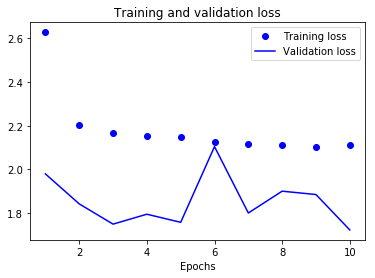

In [7]:
# Compile and fit model
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

# Visualize accuracies
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [0]:
model.save(root+'models/model_cnn_lstm.h5')

In [0]:
# Load submission file
submission = pd.read_csv(root + 'sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv(root + 'test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv(root +'submission_cnn_lstm_36_features_30_epoch.csv')

100%|██████████| 2624/2624 [02:43<00:00, 16.01it/s]
